# Ensembles

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import os
import numpy as np

# plotting
import matplotlib.pyplot as plt
import pathlib
from PIL import Image
import IPython.display as display

# to display confusion matrix
import seaborn as sn
import pandas as pd

# to determine the most voted
import collections 

### Aux functions



In [2]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [32,32])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

def show_data(s1,l1, s2,l2, labels, min):
    fig, ax = plt.subplots()
    X = np.arange(len(s1))

    models = labels
    plt.bar(X, s1, width = 0.4, color = 'b', label=l1)
    plt.bar(X + 0.4, s2, color = 'r', width = 0.4, label = l2)
    plt.xticks(X + 0.4 / 2, models)
    plt.ylim(top = 100, bottom = min)
    plt.legend(loc='upper left')
    plt.show()

def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(int(rows), columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')


def show_history(history):
    print(history.history.keys())

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='lower right')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()    


def show_accuracies(labels, test, val): 

    fig, ax = plt.subplots()
    X = np.arange(len(test))

    plt.bar(X, test, width = 0.4, color = 'b', label='test')
    plt.bar(X + 0.4, val, color = 'r', width = 0.4, label = "val")
    plt.xticks(X + 0.4 / 2, labels)
    plt.ylim(top = 1.0, bottom = 0.97)
    plt.legend(loc='upper left')
    plt.show()    



def show_misclassified(predictions, ground_truth, images, num_rows = 5, num_cols=3):
    
    # Plot the first X test images with wrong predictions.
    num_images = num_rows*num_cols
    print(num_images)
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    i = 0
    k = 0
    while k < len(images) and i < num_images:
        predicted_label = np.argmax(predictions[k])
        gt = np.where(ground_truth[k])[0][0]
        if predicted_label != gt:
            plt.subplot(num_rows, 2*num_cols, 2*i+1)
            plot_image(k, predictions[k], gt, images)
            plt.subplot(num_rows, 2*num_cols, 2*i+2)
            plot_value_array(k, predictions[k], ground_truth)
            i += 1
        k += 1
    plt.tight_layout()
    plt.show()


def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label, img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(classNames[predicted_label],
                                100*np.max(predictions_array),
                                classNames[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(8))
    plt.yticks([])
    thisplot = plt.bar(range(8), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[np.where(true_label)[0][0]].set_color('blue')   



def show_confusion_matrix(mat, classes):

    df_cm = pd.DataFrame(mat, range(classes), range(classes))
    plt.figure(figsize=(15,10))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d') # font size

    plt.show()    

In [3]:
def prepare_callbacks(file_path):

    checkpointer = ModelCheckpoint(filepath= file_path, 
                               monitor = 'val_accuracy',
                               verbose=1, 
                               save_weights_only=True,
                               save_best_only=True)


    earlyStopper = EarlyStopping(monitor='val_loss', min_delta = 0.0001, patience = 15, verbose = 1)

    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000000001, verbose = 1)

    return [checkpointer, earlyStopper, reduceLR]
    

### Batch size

Batch size is an important parameter when training a network. It can influence speed and generalization, not necessarily in the same direction. There is no golden rule for the batch size but 32 is a commom number to start with.

In here we go to 64 to achieve faster training epochs (rather than 32)

See: https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/



In [6]:
BATCH_SIZE = 64
IMAGE_SIZE = 32

DATA_PREFIX = 'd:/vcpi/gtsrb/'

TRAIN_ONLINE = False # if True it will train models, otherwise it will load weights
WEIGHT_FILE_PREFIX = 'd:/vcpi/DL06/model_'

### Prepare to load images

In [7]:
data_dir = pathlib.Path(DATA_PREFIX + 'train/')
  
classNames = np.array(os.listdir(data_dir))
NUM_CLASSES = len(classNames)
classNames


array(['00000', '00001', '00002', '00003', '00004', '00005', '00006',
       '00007'], dtype='<U5')

### Loading images takes place in here

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files(DATA_PREFIX + 'train/*/*.png')
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)



### Information about image shape and size of training set

In [9]:
t = next(iter(dataset))
print(t[0].shape, t[1].shape)

# note: this only works if dataset is not repeating
dataset_length = tf.data.experimental.cardinality(dataset).numpy()
print("Total images in dataset: ", dataset_length)  

(32, 32, 3) (8,)
Total images in dataset:  10200


### Preparing training, validation and test datasets

In [10]:

dataSolo = dataset
dataSolo = dataSolo.cache()
dataSolo = dataSolo.shuffle(buffer_size = dataset_length)
dataSolo = dataSolo.prefetch(buffer_size=10200)
dataSolo = dataSolo.batch(batch_size=BATCH_SIZE)

In [11]:
val_listset = tf.data.Dataset.list_files(DATA_PREFIX + 'val/*/*.png')
val_dataset_length = val_listset.cardinality().numpy()
print("Total images in validatation dataset: ", val_dataset_length)

valset = val_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
valset = valset.cache()
valset = valset.shuffle(buffer_size = 2580)
valset = valset.batch(batch_size = 2580)
valset = valset.prefetch(buffer_size = AUTOTUNE)


Total images in validatation dataset:  2580


In [12]:
test_listset = tf.data.Dataset.list_files(DATA_PREFIX + 'test/*/*.png')
test_dataset_length = test_listset.cardinality().numpy()
print("Total images in validatation dataset: ", test_dataset_length)

testset = test_listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)
testset = testset.batch(batch_size = BATCH_SIZE)


Total images in validatation dataset:  4170


### Show a batch of training images

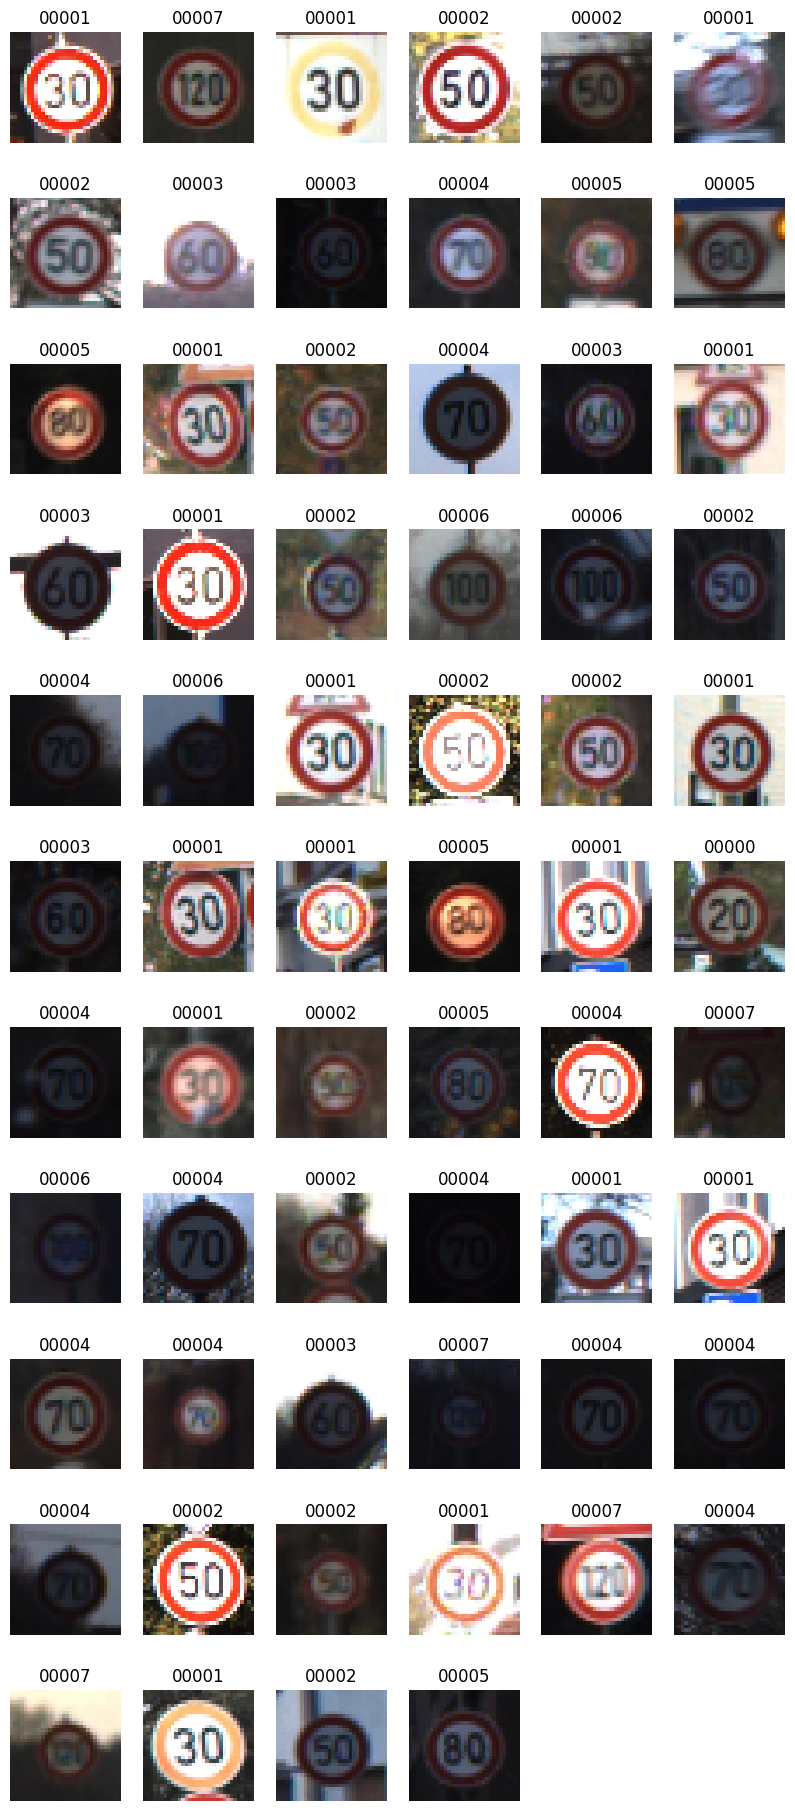

In [13]:
        
        
image_batch, label_batch = next(iter(dataSolo))        
show_batch(image_batch, label_batch.numpy())

### Build a CNN network

In [20]:
def create_model(classCount, imgSize, channels):

    modelLogits = Sequential()
    
    modelLogits.add(Conv2D(128, (5, 5), 
                     input_shape=(imgSize, imgSize, channels)
                     ))         
    modelLogits.add(BatchNormalization())
    modelLogits.add(LeakyReLU(alpha=0.01))   
    
    modelLogits.add(Conv2D(128, (5, 5) )) 
    modelLogits.add(BatchNormalization())
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))

    modelLogits.add(Conv2D(256, (5, 5) ) )   
    modelLogits.add(BatchNormalization())
    modelLogits.add(LeakyReLU(alpha=0.01))
    modelLogits.add(MaxPooling2D(pool_size=(2, 2)))
    
    modelLogits.add(Flatten())
    modelLogits.add(Dense(128))
    modelLogits.add(LeakyReLU(alpha=0.01))             
    modelLogits.add(Dropout(0.2))

    modelLogits.add(Dense(classCount))
    
    output = Activation('softmax')(modelLogits.output)

    model = tf.keras.Model(modelLogits.inputs, output)
    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ 'accuracy'])
    return model, modelLogits

    


In [21]:
NUM_MODELS = 9
file_path_prefix = f'{WEIGHT_FILE_PREFIX}V1'

In [22]:
def train_models(train, val,file_path_prefix):

    models = []
    histories = []
    
    for i in range(NUM_MODELS):

        model, modelL = create_model(NUM_CLASSES,IMAGE_SIZE,3)

        if TRAIN_ONLINE:
            callbacks = prepare_callbacks(f'{file_path_prefix}_{i:02}/cp.ckpt')

            hist = model.fit(train, 
                            epochs=100, 
                            validation_data = val, 
                            callbacks = callbacks)

        models.append([model, modelL])
        histories.append(hist)
    
    return models,histories
 


models_V1, histories_V1 = train_models(dataSolo, valset, file_path_prefix)

Epoch 1/100
160/160 [==============================] - ETA: 0s - loss: 0.7523 - accuracy: 0.7474
Epoch 1: val_accuracy improved from -inf to 0.18605, saving model to d:/vcpi/DL06/model_V1_00\cp.ckpt
160/160 [==============================] - 13s 33ms/step - loss: 0.7523 - accuracy: 0.7474 - val_loss: 2.0695 - val_accuracy: 0.1860 - lr: 1.0000e-04
Epoch 2/100
156/160 [============================>.] - ETA: 0s - loss: 0.1195 - accuracy: 0.9694
Epoch 2: val_accuracy improved from 0.18605 to 0.38837, saving model to d:/vcpi/DL06/model_V1_00\cp.ckpt
160/160 [==============================] - 2s 10ms/step - loss: 0.1183 - accuracy: 0.9697 - val_loss: 1.5740 - val_accuracy: 0.3884 - lr: 1.0000e-04
Epoch 3/100
154/160 [===========================>..] - ETA: 0s - loss: 0.0431 - accuracy: 0.9924
Epoch 3: val_accuracy improved from 0.38837 to 0.69845, saving model to d:/vcpi/DL06/model_V1_00\cp.ckpt
160/160 [==============================] - 2s 10ms/step - loss: 0.0428 - accuracy: 0.9925 - val_lo

In [23]:
def load_weights(models, file_path_prefix):

    for i in range(NUM_MODELS):

        file_path = f'{file_path_prefix}_{i:02}/cp.ckpt'

        models[i][0].load_weights(file_path)
        models[i][0].save('temp.hdf5')
        models[i][1].load_weights('temp.hdf5', by_name=True)
    

load_weights(models_V1, file_path_prefix)
   

### Evaluate Models

In [24]:
def evaluate_models(models):
    
    accuracy = 0

    for i in range(NUM_MODELS):

        eval = models[i][0].evaluate(testset, verbose = 2)
        accuracy += eval[1]

    print(f'average accuracy: {(accuracy/NUM_MODELS)*100:.3f}')    


evaluate_models(models_V1)

66/66 - 2s - loss: 0.0825 - accuracy: 0.9782 - 2s/epoch - 28ms/step
66/66 - 1s - loss: 0.0856 - accuracy: 0.9729 - 611ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0852 - accuracy: 0.9741 - 855ms/epoch - 13ms/step
66/66 - 1s - loss: 0.1230 - accuracy: 0.9667 - 912ms/epoch - 14ms/step
66/66 - 1s - loss: 0.0805 - accuracy: 0.9782 - 675ms/epoch - 10ms/step
66/66 - 1s - loss: 0.0882 - accuracy: 0.9763 - 627ms/epoch - 10ms/step
66/66 - 1s - loss: 0.1005 - accuracy: 0.9710 - 699ms/epoch - 11ms/step
66/66 - 1s - loss: 0.1101 - accuracy: 0.9655 - 631ms/epoch - 10ms/step
66/66 - 1s - loss: 0.1098 - accuracy: 0.9679 - 669ms/epoch - 10ms/step
average accuracy: 97.229


In [25]:
def get_labels_logits_and_preds(models):

    preds = [[] for _ in range(NUM_MODELS) ]
    logits = [[] for _ in range(NUM_MODELS)]
    labels = []
    for images, labs in testset.take(-1):

        labels.extend(labs.numpy())
        for i in range(NUM_MODELS):

            preds[i].extend(models[i][0].predict(images))
            logits[i].extend(models[i][1].predict(images))

    labels = [np.argmax(i) for i in labels]  
    
    return labels, logits, preds

labels_V1, logits_V1, preds_V1 = get_labels_logits_and_preds(models_V1)

1/1 [==============================] - 0s 75ms/step


In [26]:
def get_class_preds(preds):

    class_preds = []

    for i in range(test_dataset_length):

        c = []
        for m in range(NUM_MODELS):

            c.append(np.argmax(preds[m][i]))
        class_preds.append(c)
        
    return class_preds


class_preds_V1 = get_class_preds(preds_V1)

In [27]:
def get_class_from_sum_of_logits(logits):

    sum_logits = []

    for i in range(test_dataset_length):

        log = logits[0][i]
        for m in range(1, NUM_MODELS):
            log = np.add(log, logits[m][i])
        sum_logits.append(np.argmax(log))
    return(sum_logits)
    
class_logits_V1 = get_class_from_sum_of_logits(logits_V1)    

In [28]:
def get_stats(labels, class_preds, class_logits):

    all_correct = 0
    all_incorrect = 0
    maj_vote = 0
    maj_wrong = 0
    tie = 0
    count = 0
    log_ok = 0
    log_ko = 0

    for k in range(test_dataset_length):

        counter = collections.Counter(class_preds[k])
        if len(counter) == 1:
            if counter.most_common(1)[0][0] == labels[k]:
                all_correct += 1
            else:
                all_incorrect += 1
        else:
            aux = counter.most_common(2)
            if aux[0][1] > aux[1][1] and aux[0][0] == labels[k]:
                maj_vote += 1
            if aux[0][1] > aux[1][1] and aux[0][0] != labels[k]:
                maj_wrong += 1
            elif aux[0][1] == aux[1][1]:
                tie += 1
        if class_logits[k] == labels[k]:
            log_ok += 1
        else:
            log_ko += 1
        count += 1 
        
    return [count, all_correct, all_incorrect, maj_vote, tie, maj_wrong, log_ok, log_ko]
    
    
res = get_stats(labels_V1, class_preds_V1, class_logits_V1)
print(res, res[6]/res[0])

[4170, 3896, 27, 179, 1, 67, 4075, 95] 0.9772182254196643


# Version II - dynamic data augmentation

### Function to transform image

In [29]:


#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa


def process_image(image, label):
    
    # random rotate 5 degrees
    r = tf.random.uniform(shape=(), minval=-0.175, maxval=0.175, dtype=tf.dtypes.float32)
    image = tfa.image.rotate(image, r)

    # translate image up to 10%
    rx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    ry = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32) 
    image = tfa.image.translate(image, [rx, ry])
   
    # change hue, saturation and value
    image = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.2, 0.4, 1.1, 0.4, 1.1),0,1)

    return image, label

In [30]:
dataV2 = dataset
dataV2 = dataV2.cache()
dataV2 = dataV2.shuffle(buffer_size = dataset_length)
dataV2 = dataV2.map(process_image)
dataV2 = dataV2.prefetch(buffer_size=10200)
dataV2 = dataV2.batch(batch_size=BATCH_SIZE)


In [31]:
file_path_prefix = f'{WEIGHT_FILE_PREFIX}V2'    
models_V2, histories_V2 = train_models(dataV2, valset,file_path_prefix)
    

Epoch 1/100
158/160 [============================>.] - ETA: 0s - loss: 1.5748 - accuracy: 0.4169
Epoch 1: val_accuracy improved from -inf to 0.24186, saving model to d:/vcpi/DL06/model_V2_00\cp.ckpt
160/160 [==============================] - 6s 24ms/step - loss: 1.5710 - accuracy: 0.4184 - val_loss: 2.0031 - val_accuracy: 0.2419 - lr: 1.0000e-04
Epoch 2/100
159/160 [============================>.] - ETA: 0s - loss: 0.7480 - accuracy: 0.7497
Epoch 2: val_accuracy improved from 0.24186 to 0.63876, saving model to d:/vcpi/DL06/model_V2_00\cp.ckpt
160/160 [==============================] - 4s 25ms/step - loss: 0.7475 - accuracy: 0.7497 - val_loss: 1.3721 - val_accuracy: 0.6388 - lr: 1.0000e-04
Epoch 3/100
159/160 [============================>.] - ETA: 0s - loss: 0.3814 - accuracy: 0.8825
Epoch 3: val_accuracy improved from 0.63876 to 0.76473, saving model to d:/vcpi/DL06/model_V2_00\cp.ckpt
160/160 [==============================] - 4s 23ms/step - loss: 0.3815 - accuracy: 0.8824 - val_los

In [32]:
load_weights(models_V2, file_path_prefix)

In [33]:
evaluate_models(models_V2)


66/66 - 2s - loss: 0.0742 - accuracy: 0.9779 - 2s/epoch - 35ms/step
66/66 - 1s - loss: 0.0731 - accuracy: 0.9789 - 608ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0500 - accuracy: 0.9871 - 581ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0689 - accuracy: 0.9815 - 613ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0697 - accuracy: 0.9803 - 568ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0979 - accuracy: 0.9724 - 608ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0748 - accuracy: 0.9835 - 565ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0677 - accuracy: 0.9803 - 579ms/epoch - 9ms/step
66/66 - 1s - loss: 0.0608 - accuracy: 0.9818 - 838ms/epoch - 13ms/step
average accuracy: 98.042


In [34]:
labels_V2, logits_V2, preds_V2 = get_labels_logits_and_preds(models_V2)
class_preds_V2 = get_class_preds(preds_V2)
class_logits_V2 = get_class_from_sum_of_logits(logits_V2) 

res = get_stats(labels_V2, class_preds_V2, class_logits_V2)
print(res, res[6]/res[0]*100)

1/1 [==============================] - 0s 77ms/step
[4170, 3980, 18, 118, 6, 48, 4104, 66] 98.41726618705036


# Version III - Massive data augmentation

### Data augmentation functions

In [35]:
import tensorflow_addons as tfa

def process_brightness(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 1.0, 0.1, 3.0),0,1)
    return img, label

def process_saturation(image, label):
    
    img = tf.clip_by_value(tfa.image.random_hsv_in_yiq(image, 0.0, 1.0, 3.0, 1.0, 1.0),0,1)
    return img, label

def process_contrast(image, label):
    
    img = tf.clip_by_value(tf.image.random_contrast(image, lower=0.1, upper=3.0, seed=None), 0, 1)
    return img, label

def process_hue(image, label):
    
    img = tf.image.random_hue(image, max_delta=0.2, seed=None)
    return img, label

def process_rotate(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    return img, label

def process_shear(image, label):
    
    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    sx = tf.random.uniform(shape=(), minval=-0.1, maxval=0.1, dtype=tf.dtypes.float32)
    img = tfa.image.transform(img, [1, sx, -sx*32,   0,1,0,  0,0])
    return img, label

def process_translate(image, label):

    img = tfa.image.rotate(image, tf.random.uniform(shape=(), minval=-0.175, maxval=0.175))
    tx = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)
    ty = tf.random.uniform(shape=(), minval=-3, maxval=3, dtype=tf.dtypes.float32)  
    img = tfa.image.translate(img, [tx,ty])
    return img, label

def process_crop(image, label):
    
    c = tf.random.uniform(shape=(), minval=24, maxval=32, dtype=tf.dtypes.float32)
    img = tf.image.random_crop(image, size=[c,c,3])
    img = tf.image.resize(img ,size= [32,32])
    return img, label

In [36]:
dataV3 = dataset
# color ops
dataV3 = dataV3.map(process_brightness)
dataV3 = dataV3.concatenate(dataset.map(process_contrast))
dataV3 = dataV3.concatenate(dataset.map(process_hue))
dataV3 = dataV3.concatenate(dataset.map(process_saturation))

#geometry ops
dataV3 = dataV3.concatenate(dataset.map(process_rotate))
dataV3 = dataV3.concatenate(dataset.map(process_shear))
dataV3 = dataV3.concatenate(dataset.map(process_translate))
dataV3 = dataV3.concatenate(dataset.map(process_crop))

dataV3 = dataV3.cache()
dataV3 = dataV3.shuffle(buffer_size = 81600)
dataV3 = dataV3.batch(batch_size = BATCH_SIZE)
dataV3 = dataV3.prefetch(buffer_size = AUTOTUNE)




In [37]:
file_path_prefix = f'{WEIGHT_FILE_PREFIX}V3'    
models_V3, histories_V3 = train_models(dataV3, valset,file_path_prefix)

Epoch 1/100
1272/1275 [============================>.] - ETA: 0s - loss: 0.3533 - accuracy: 0.8856
Epoch 1: val_accuracy improved from -inf to 0.97209, saving model to d:/vcpi/DL06/model_V3_00\cp.ckpt
1275/1275 [==============================] - 76s 8ms/step - loss: 0.3527 - accuracy: 0.8858 - val_loss: 0.0899 - val_accuracy: 0.9721 - lr: 1.0000e-04
Epoch 2/100
1268/1275 [============================>.] - ETA: 0s - loss: 0.0834 - accuracy: 0.9751
Epoch 2: val_accuracy did not improve from 0.97209
1275/1275 [==============================] - 9s 7ms/step - loss: 0.0832 - accuracy: 0.9752 - val_loss: 0.1190 - val_accuracy: 0.9593 - lr: 1.0000e-04
Epoch 3/100
1274/1275 [============================>.] - ETA: 0s - loss: 0.0550 - accuracy: 0.9828
Epoch 3: val_accuracy improved from 0.97209 to 0.97791, saving model to d:/vcpi/DL06/model_V3_00\cp.ckpt
1275/1275 [==============================] - 10s 8ms/step - loss: 0.0550 - accuracy: 0.9828 - val_loss: 0.0664 - val_accuracy: 0.9779 - lr: 1.00

In [38]:
load_weights(models_V3, file_path_prefix)
evaluate_models(models_V3)

66/66 - 2s - loss: 0.0673 - accuracy: 0.9887 - 2s/epoch - 31ms/step
66/66 - 1s - loss: 0.0476 - accuracy: 0.9904 - 702ms/epoch - 11ms/step
66/66 - 1s - loss: 0.0473 - accuracy: 0.9930 - 701ms/epoch - 11ms/step
66/66 - 1s - loss: 0.0491 - accuracy: 0.9938 - 704ms/epoch - 11ms/step
66/66 - 1s - loss: 0.0459 - accuracy: 0.9942 - 717ms/epoch - 11ms/step
66/66 - 1s - loss: 0.0553 - accuracy: 0.9926 - 724ms/epoch - 11ms/step
66/66 - 1s - loss: 0.0538 - accuracy: 0.9909 - 946ms/epoch - 14ms/step
66/66 - 1s - loss: 0.0656 - accuracy: 0.9909 - 964ms/epoch - 15ms/step
66/66 - 1s - loss: 0.0473 - accuracy: 0.9938 - 830ms/epoch - 13ms/step
average accuracy: 99.203


In [39]:
labels_V3, logits_V3, preds_V3 = get_labels_logits_and_preds(models_V3)
class_preds_V3 = get_class_preds(preds_V3)
class_logits_V3 = get_class_from_sum_of_logits(logits_V3) 

res = get_stats(labels_V3, class_preds_V3, class_logits_V3)
print(res, res[6]/res[0])


1/1 [==============================] - 0s 77ms/step
[4170, 4095, 8, 49, 1, 17, 4144, 26] 0.9937649880095923


# Stacked Ensemble

In [40]:
## Build list of inputs and labels for test class

test_logits_preds = []

for i in range(test_dataset_length):
    
    aux = []   
    for m in range(NUM_MODELS):        
        aux.extend(logits_V3[m][i])
        
    test_logits_preds.append(aux)
    
    
## Compute logit predictions and training labels
    


In [41]:
logits_train = [[] for _ in range(NUM_MODELS)]
labels_aux = []
for images, labs in dataV3.take(-1):
    
    labels_aux.extend(labs.numpy())
    for i in range(NUM_MODELS):
        
        logits_train[i].extend(models_V3[i][1].predict(images))
        
labels_train = [np.argmax(i) for i in labels_aux]  

## Build list of train inputs


2/2 [==============================] - 0s 3ms/step


In [42]:

train_logits_preds = []

for i in range(81600):
    
    aux = []
    
    for m in range(NUM_MODELS):
        
        aux.extend(logits_train[m][i])
        
    train_logits_preds.append(aux)

In [43]:
print(len(labels_train), len(train_logits_preds))

81600 81600


In [44]:
stack_model  = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(len(train_logits_preds[0]),)),

  tf.keras.layers.Dense(256),    
  BatchNormalization(),LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128),    
  BatchNormalization(),LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(64),    
  BatchNormalization(),LeakyReLU(alpha=0.01),
  tf.keras.layers.Dropout(0.4),

  tf.keras.layers.Dense(8, activation='softmax')
])


In [45]:

stack_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [46]:
print(len(labels_train), len(train_logits_preds), len(logits_train[0]))

81600 81600 81600


In [47]:

stack_model.fit(np.asarray(train_logits_preds),np.asarray(labels_train),epochs=100, batch_size=32,
                        validation_data = (np.asarray(test_logits_preds), np.asarray(labels_V3)))

Epoch 1/100
2550/2550 [==============================] - 14s 5ms/step - loss: 0.4006 - accuracy: 0.9036 - val_loss: 0.0330 - val_accuracy: 0.9940
Epoch 2/100
2550/2550 [==============================] - 13s 5ms/step - loss: 0.0796 - accuracy: 0.9844 - val_loss: 0.0280 - val_accuracy: 0.9930
Epoch 3/100
2550/2550 [==============================] - 13s 5ms/step - loss: 0.0473 - accuracy: 0.9891 - val_loss: 0.0272 - val_accuracy: 0.9942
Epoch 4/100
2550/2550 [==============================] - 13s 5ms/step - loss: 0.0344 - accuracy: 0.9914 - val_loss: 0.0281 - val_accuracy: 0.9930
Epoch 5/100
2550/2550 [==============================] - 13s 5ms/step - loss: 0.0288 - accuracy: 0.9928 - val_loss: 0.0296 - val_accuracy: 0.9923
Epoch 6/100
2550/2550 [==============================] - 13s 5ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0319 - val_accuracy: 0.9930
Epoch 7/100
2550/2550 [==============================] - 13s 5ms/step - loss: 0.0215 - accuracy: 0.9942 - val_loss: 0.0314 -

In [48]:
pred = stack_model.predict(np.asarray(test_logits_preds))

131/131 [==============================] - 0s 2ms/step


In [49]:
correct = 0

for i in range(test_dataset_length):
    if np.argmax(pred[i]) == labels_V3[i] :
        correct += 1
        
print(correct, correct/4170)

4133 0.9911270983213429
